In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DEVICE = 'fpga'
SUBTRACT_IDLE = True

match DEVICE:
    case 'cn': IDLE = 3.38
    case 'fpga': IDLE = 53
    case 'laptop': IDLE = 3.00

path_math = f'scripts/{DEVICE}/math.csv'
path_sleepy = f'scripts/{DEVICE}/sleepy.csv'
path_matmul = f'scripts/{DEVICE}/matmul.csv'

In [3]:
def read_csv(path):
    df = pd.read_csv(path)
    df = df[df['dynamic'] == False]
    df.drop(['dynamic'], axis=1, inplace=True)

    df['W'] = df['energy'] / df['runtime']

    if SUBTRACT_IDLE:
        df['energy'] -= df['runtime'] * IDLE
        assert((df['energy'] > 0).all())

    real_max = df['runtime'] * df['threads']
    user_pct = df['usertime'] / real_max
    user_pct = user_pct.clip(upper=1.0)
    df['usertime'] /= df['threads']
    df['user-pct'] = user_pct
    df['energy-user'] = df['energy'] * user_pct

    df0 = df.copy()[df['busy'] == 0]
    return df, df0

In [4]:
df_math,   df_math0   = read_csv(path_math)
df_sleepy, df_sleepy0 = read_csv(path_sleepy)
df_matmul, df_matmul0 = read_csv(path_matmul)
df_matmul

,busy,threads,energy,runtime,usertime,W,user-pct,energy-user
0,0,1,23.309572,0.405642,0.405640,110.463380,0.999994,23.309428
1,0,2,12.867782,0.203320,0.202774,116.288350,0.997314,12.833217
2,0,3,10.441882,0.148841,0.135297,123.154476,0.909004,9.491711
3,0,4,7.949403,0.103831,0.102034,129.561240,0.982701,7.811886
4,0,5,7.290312,0.089707,0.081672,134.268272,0.910428,6.637304
...,...,...,...,...,...,...,...,...
251,28,28,6.347508,0.030270,0.015204,262.694111,0.502278,3.188214
252,28,29,6.665272,0.030959,0.014723,268.292971,0.475565,3.169769
253,28,30,6.940892,0.032317,0.014401,267.774273,0.445601,3.092870
254,28,31,6.338985,0.029501,0.013977,267.874438,0.473793,3.003365


In [5]:
df_math_speedup   = df_math.copy()
df_sleepy_speedup = df_sleepy.copy()
df_matmul_speedup = df_matmul.copy()

for col in df_math_speedup.columns[2:]:
    df_math_speedup[col]   = df_math_speedup[col].iloc[0]   / df_math_speedup[col]
    df_sleepy_speedup[col] = df_sleepy_speedup[col].iloc[0] / df_sleepy_speedup[col]
    df_matmul_speedup[col] = df_matmul_speedup[col].iloc[0] / df_matmul_speedup[col]

df_math_speedup0   = df_math_speedup[df_math_speedup['busy'] == 0]
df_sleepy_speedup0 = df_sleepy_speedup[df_sleepy_speedup['busy'] == 0]
df_matmul_speedup0 = df_matmul_speedup[df_matmul_speedup['busy'] == 0]

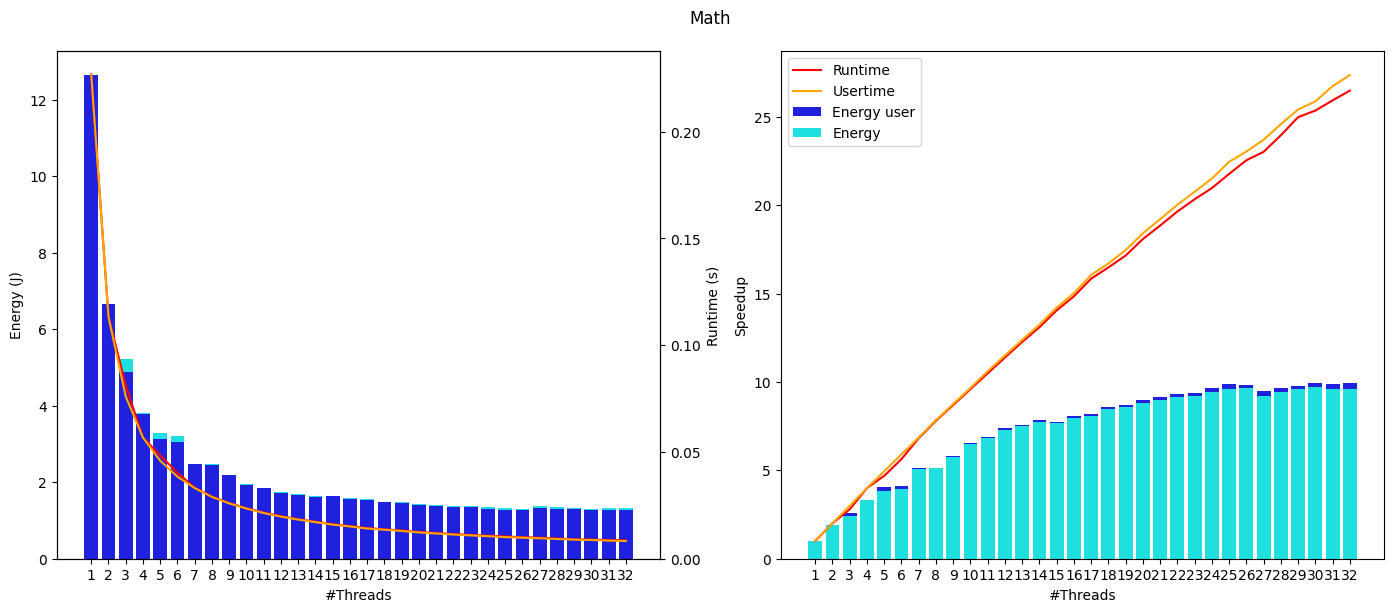

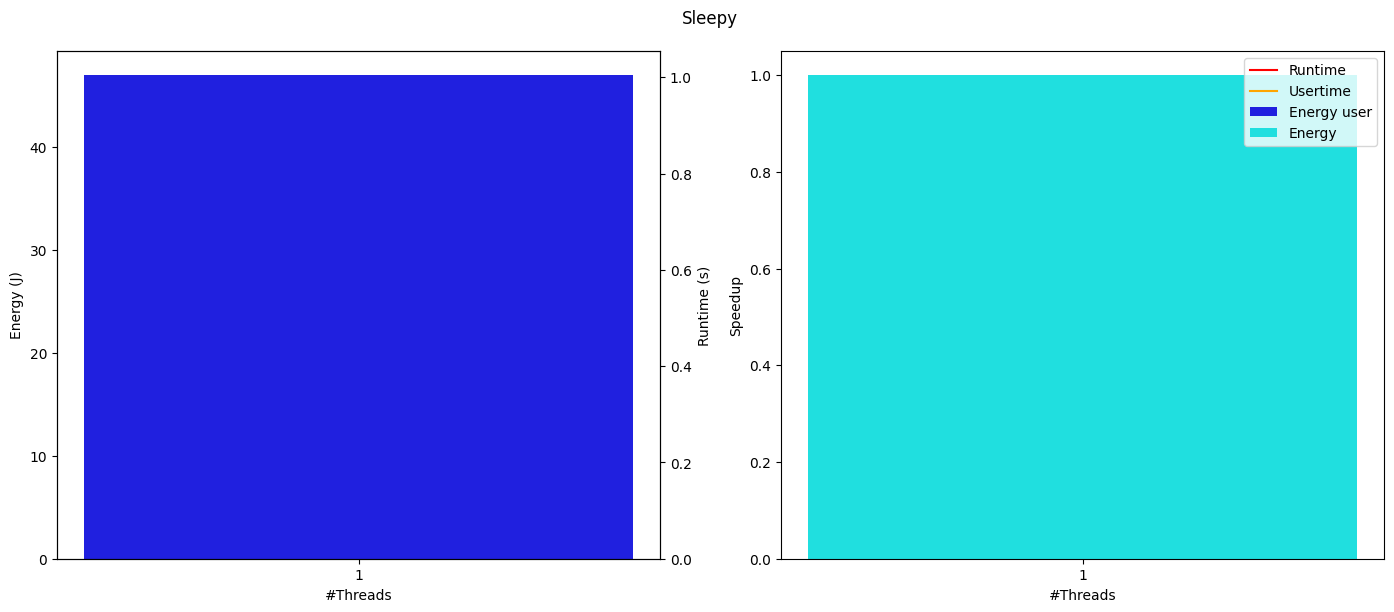

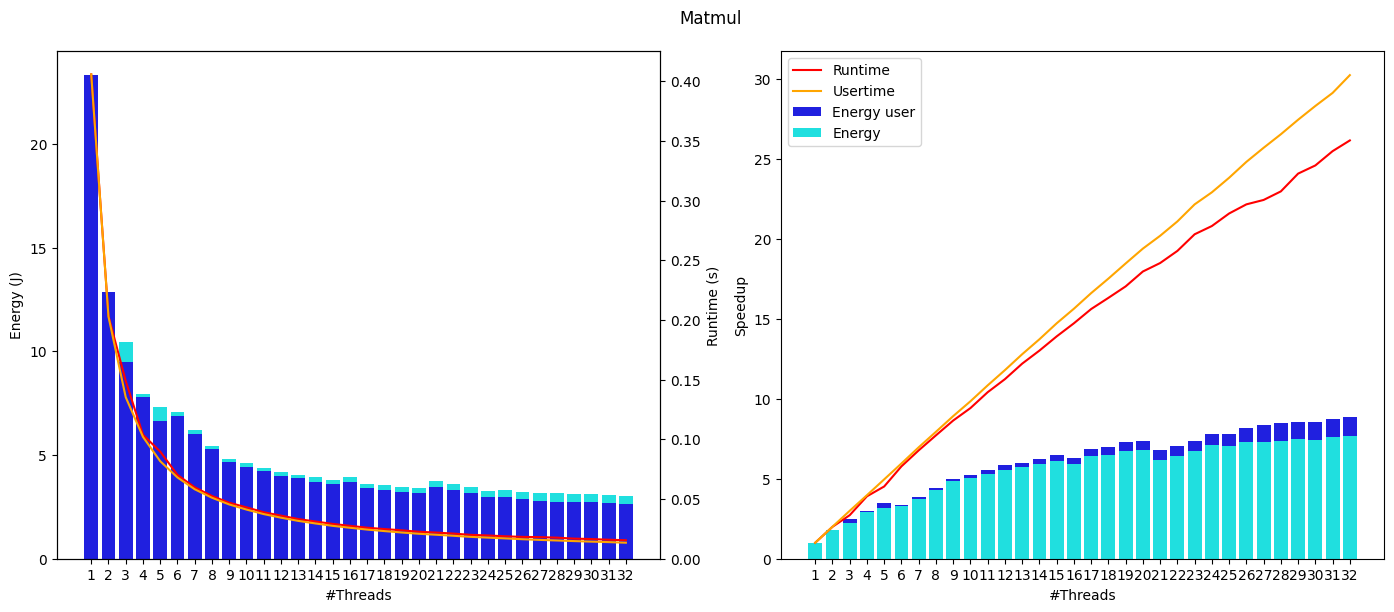

In [6]:
def plot(title, df0, df_speedup0):
    fig, (ax_energy1, ax_speedup) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    
    # Energy
    sns.barplot(df0, x='threads', y='energy', legend=False, color='cyan', ax=ax_energy1)
    sns.barplot(df0, x='threads', y='energy-user', legend=False, color='blue', ax=ax_energy1)
    ax_energy2 = ax_energy1.twinx()
    sns.lineplot(df0, x=df0.index, y='runtime', legend=False, color='r', ax=ax_energy2)
    sns.lineplot(df0, x=df0.index, y='usertime', legend=False, color='orange', ax=ax_energy2)

    ax_energy1.set_xlabel('#Threads')
    ax_energy1.set_ylabel('Energy (J)')
    ax_energy2.set_ylabel('Runtime (s)')
    ax_energy2.set_ylim((0, None))

    # Speedup
    sns.barplot(df_speedup0, x='threads', y='energy-user', label='Energy user', color='blue', ax=ax_speedup)
    sns.barplot(df_speedup0, x='threads', y='energy', label='Energy', color='cyan', ax=ax_speedup)
    sns.lineplot(df_speedup0, x=df_speedup0.index, y='runtime', label='Runtime', color='r', ax=ax_speedup)
    sns.lineplot(df_speedup0, x=df_speedup0.index, y='usertime', label='Usertime', color='orange', ax=ax_speedup)

    ax_speedup.set_xlabel('#Threads')
    ax_speedup.set_ylabel('Speedup')
    ax_speedup.set_ylim((0, None))

    plt.show()

plot('Math', df_math0, df_math_speedup0)
plot('Sleepy', df_sleepy0, df_sleepy_speedup0)
plot('Matmul', df_matmul0, df_matmul_speedup0)

# With busy threads

In [7]:
ENERGY = 'energy'

print('Math:')
for (busy, df_busy) in df_math.groupby('busy'):
    best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(best['threads'])
    energy = best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

    r_best = df_busy[df_busy['runtime'] == df_busy['runtime'].min()].iloc[0]
    threads = int(r_best['threads'])
    runtime = r_best['runtime']
    print(f'          Best: {threads:2d} threads @ {runtime:.2f}s ({busy + threads} total workers)')

print()

print('Sleepy:')
for (busy, df_busy) in df_sleepy.groupby('busy'):
    best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(best['threads'])
    energy = best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

print()

print('Matmul:')
for (busy, df_busy) in df_matmul.groupby('busy'):
    e_best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(e_best['threads'])
    energy = e_best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

    r_best = df_busy[df_busy['runtime'] == df_busy['runtime'].min()].iloc[0]
    threads = int(r_best['threads'])
    runtime = r_best['runtime']
    print(f'          Best: {threads:2d} threads @ {runtime:.2f}s ({busy + threads} total workers)')

Math:
 0 busy - Best: 30 threads @ 1.30J (30 total workers)
          Best: 32 threads @ 0.01s (32 total workers)
 4 busy - Best: 27 threads @ 1.40J (31 total workers)
          Best: 28 threads @ 0.01s (32 total workers)
 8 busy - Best: 23 threads @ 1.55J (31 total workers)
          Best: 24 threads @ 0.01s (32 total workers)
12 busy - Best: 20 threads @ 1.76J (32 total workers)
          Best: 20 threads @ 0.01s (32 total workers)
16 busy - Best: 16 threads @ 1.94J (32 total workers)
          Best: 16 threads @ 0.01s (32 total workers)
20 busy - Best: 12 threads @ 2.55J (32 total workers)
          Best: 12 threads @ 0.02s (32 total workers)
24 busy - Best:  8 threads @ 3.78J (32 total workers)
          Best:  8 threads @ 0.03s (32 total workers)
28 busy - Best: 32 threads @ 6.79J (60 total workers)
          Best: 32 threads @ 0.05s (60 total workers)
32 busy - Best: 25 threads @ 4.95J (57 total workers)
          Best: 25 threads @ 0.04s (57 total workers)

Sleepy:
 0 busy - Bes

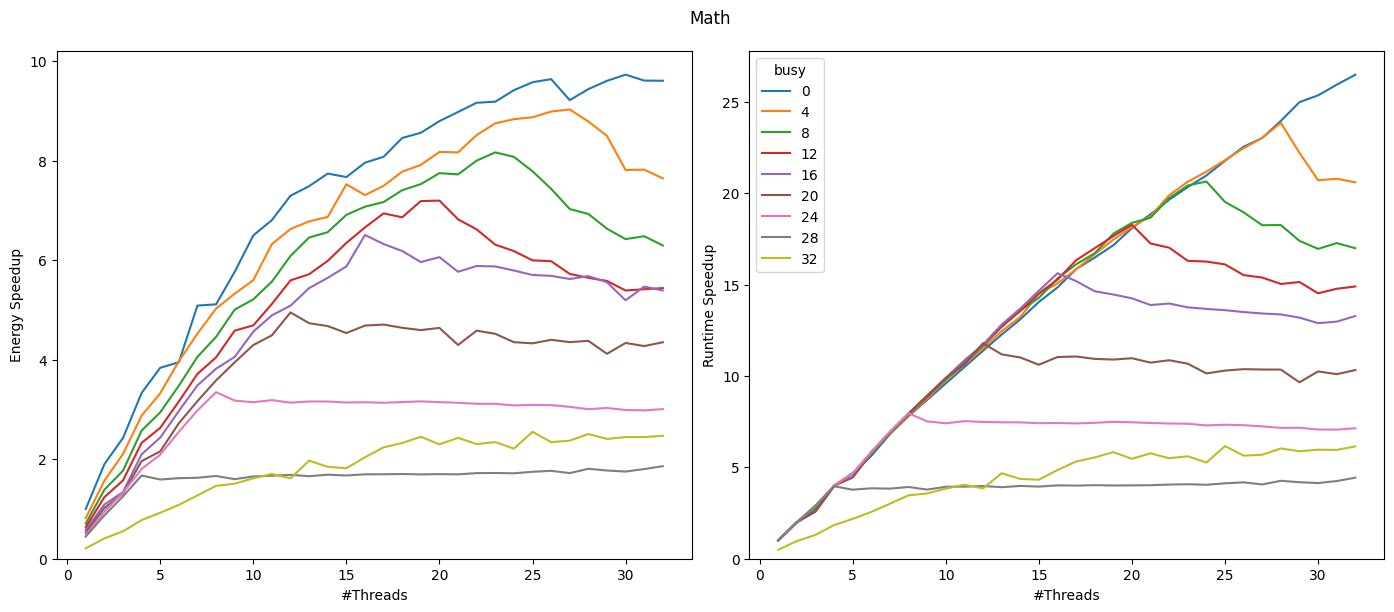

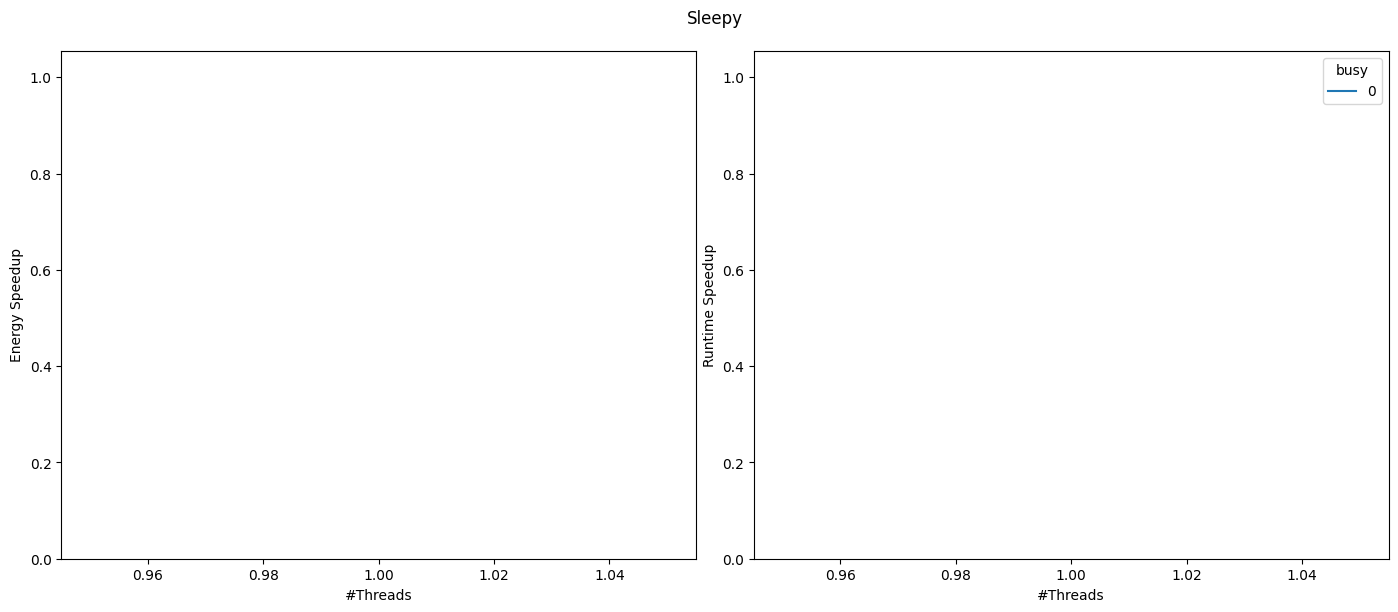

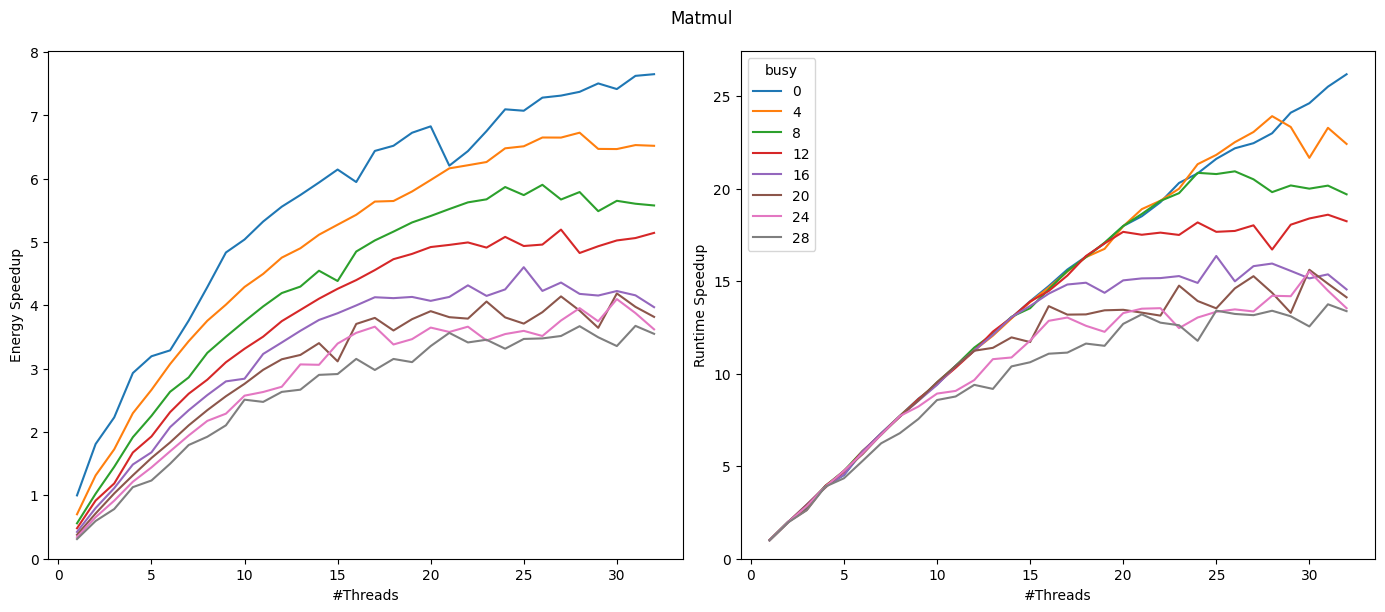

In [8]:
def plot(title, df):
    fig, (ax_energy, ax_runtime) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()

    # Energy
    sns.lineplot(df, x='threads', y='energy', hue=df['busy'].astype('category'), ax=ax_energy, legend=False)
    ax_energy.set_xlabel('#Threads')
    ax_energy.set_ylabel('Energy Speedup')
    ax_energy.set_ylim((0, None))

    # Runtime
    sns.lineplot(df, x='threads', y='runtime', hue=df['busy'].astype('category'), ax=ax_runtime)
    ax_runtime.set_xlabel('#Threads')
    ax_runtime.set_ylabel('Runtime Speedup')
    ax_runtime.set_ylim((0, None))

    plt.show()

plot('Math', df_math_speedup)
plot('Sleepy', df_sleepy_speedup)
plot('Matmul', df_matmul_speedup)

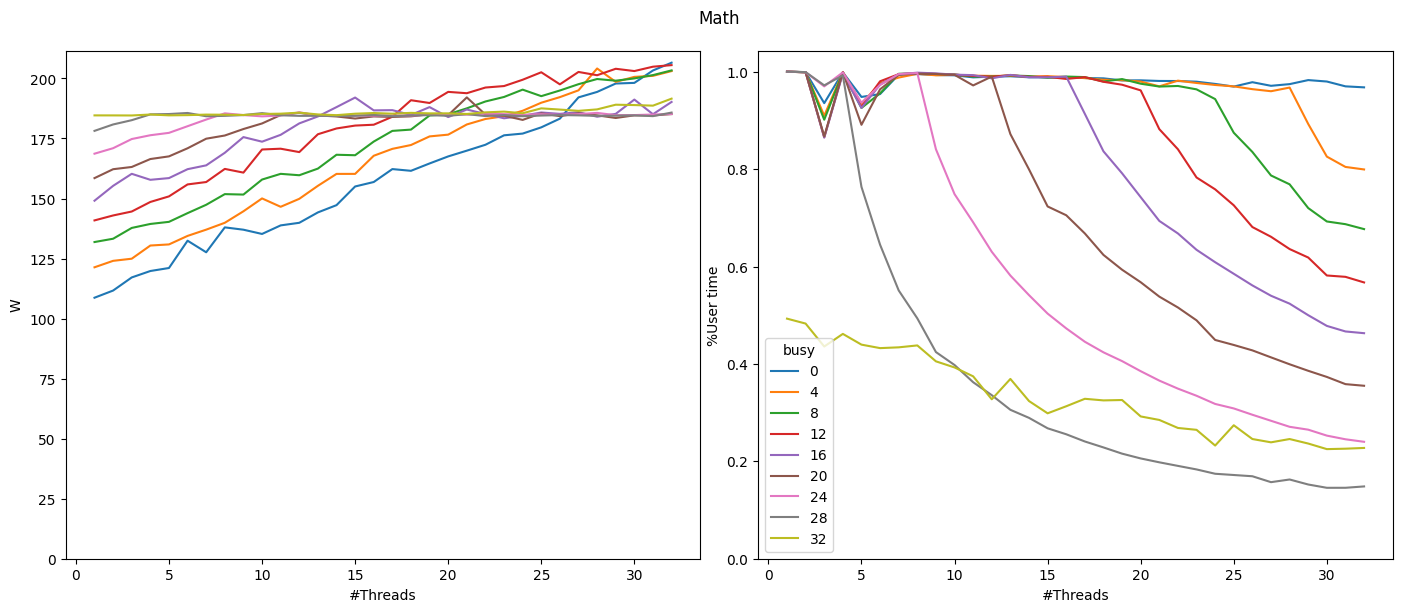

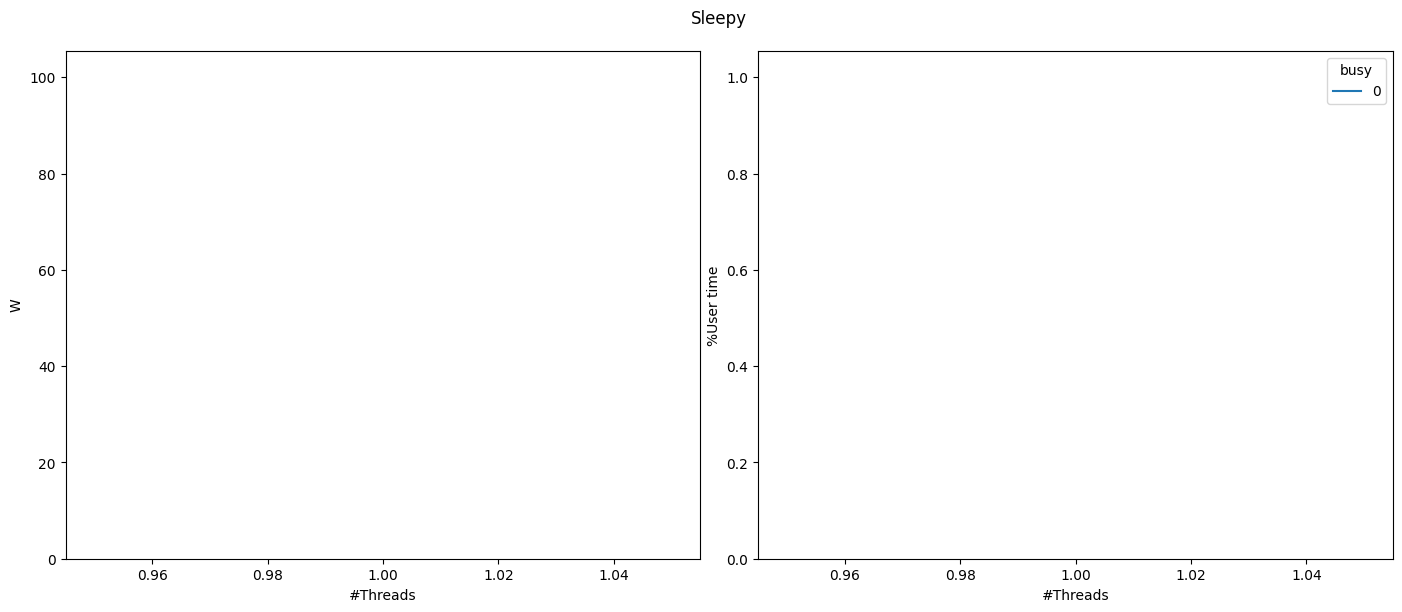

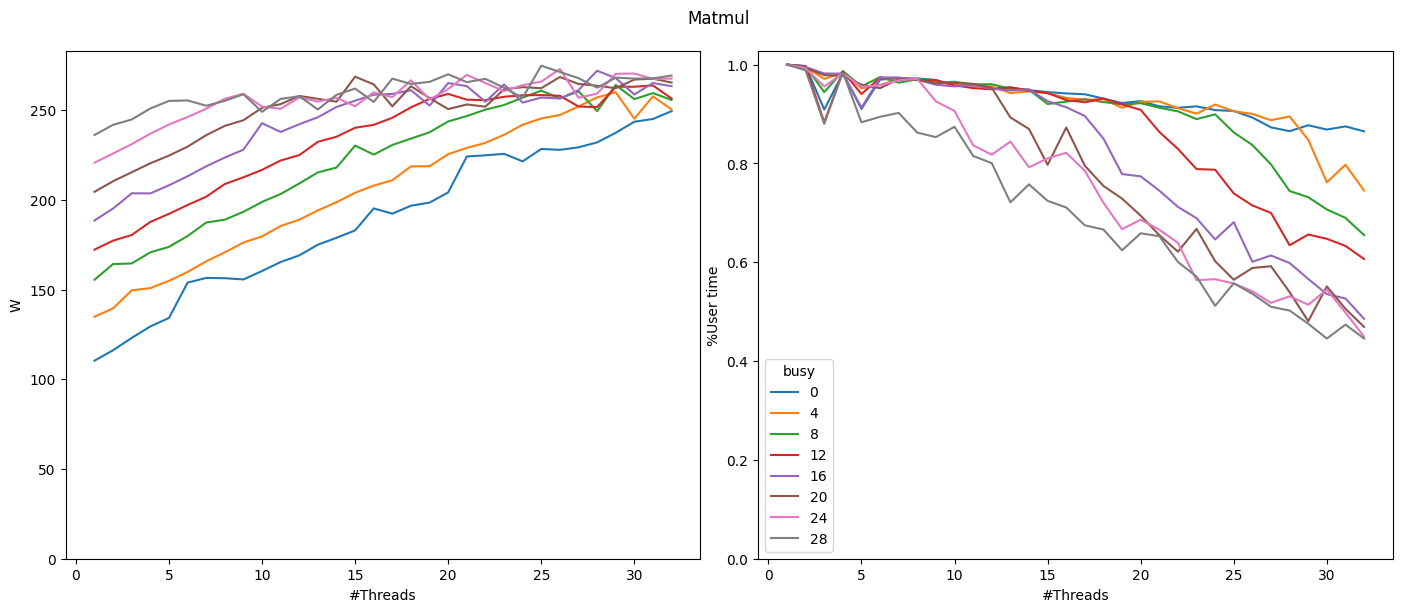

In [9]:
def plot(title, df):
    fig, (ax_power, ax_user) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()

    # Power
    sns.lineplot(df, x='threads', y='W', hue=df['busy'].astype('category'), ax=ax_power, legend=False)
    ax_power.set_xlabel('#Threads')
    ax_power.set_ylim((0, None))

    # User pct
    sns.lineplot(df, x='threads', y='user-pct', hue=df['busy'].astype('category'), ax=ax_user)
    ax_user.set_xlabel('#Threads')
    ax_user.set_ylabel('%User time')
    ax_user.set_ylim((0, None))

    plt.show()

plot('Math', df_math)
plot('Sleepy', df_sleepy)
plot('Matmul', df_matmul)